In [1]:
import pickle
from functools import partial
from os import listdir
from os.path import isfile, join

import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from common import CityResult
from file_name_generator import generate_new_name


Загрузка данных

In [2]:
mypath = '../clusters_results/few_city/v2'

In [3]:
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

r : dict[str:CityResult]= {}
for name in onlyfiles:
    if 'ASHA' in name:
        continue
    with open(join(mypath, name), 'rb') as f:
        r[name] = pickle.load(f)
        f.close()

Обработка данных

mean centroids b: 2.030701581413767 +- 0.35350300792797856
mean centroids b: 2.0023683687949636 +- 0.19073642847260686
mean centroids b: 1.649639835981808 +- 0.1981202865049448
mean centroids b: 1.485346193842694 +- 0.11333045988762155
mean centroids b: 2.145339798085708 +- 0.2161016415218276
mean centroids b: 1.995676381430036 +- 0.30672327799128263
mean centroids b: 2.033264741539798 +- 0.36679822659446093
mean centroids b: 1.7572820731197054 +- 0.17138538533102335
mean centroids b: 1.8734681365015553 +- 0.1707723913904737
mean centroids b: 1.8350613122267196 +- 0.1464995795313568
mean centroids b: 1.9223885296562089 +- 0.2416169855899316


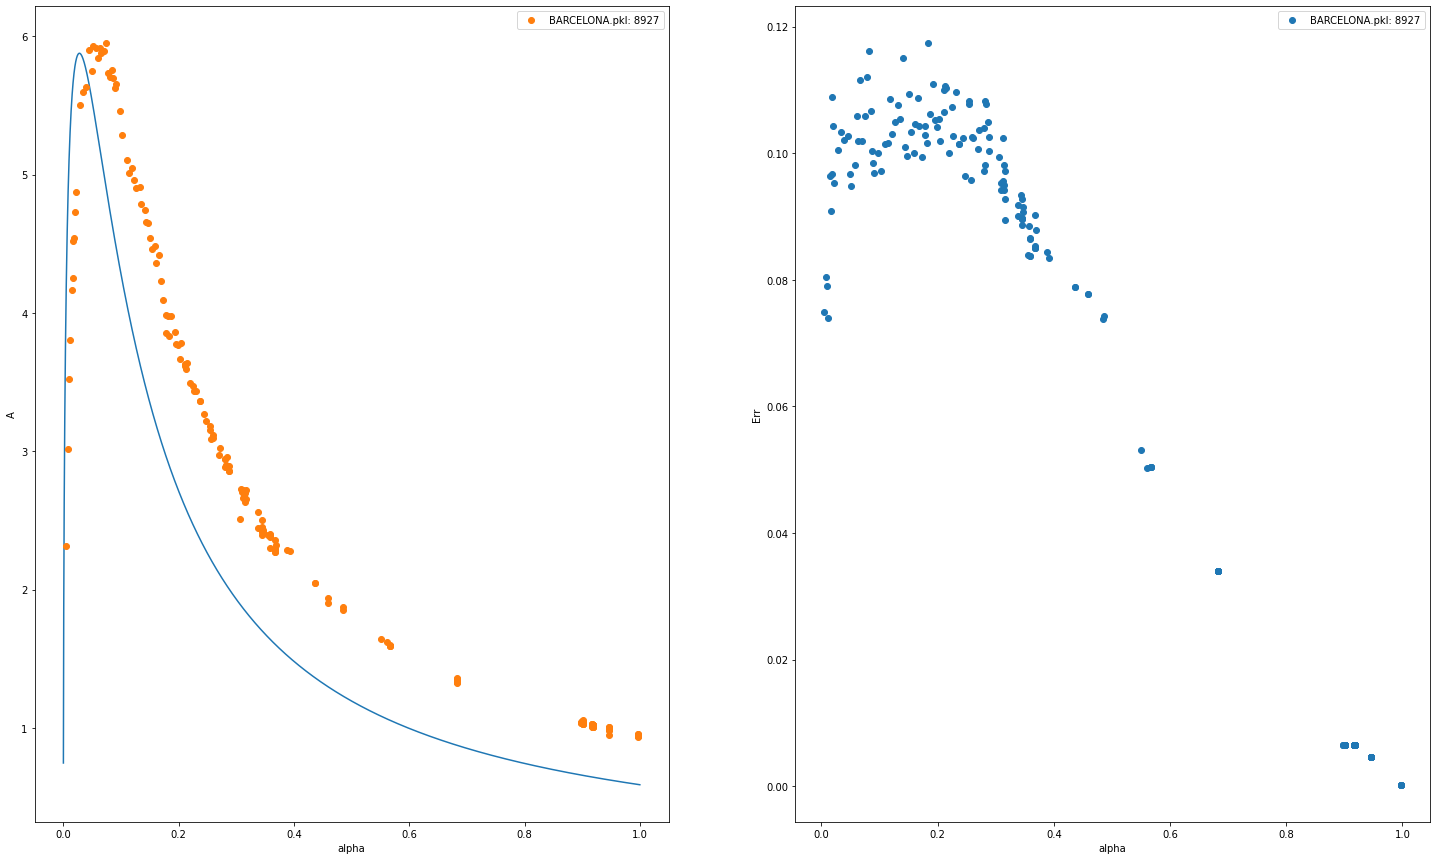

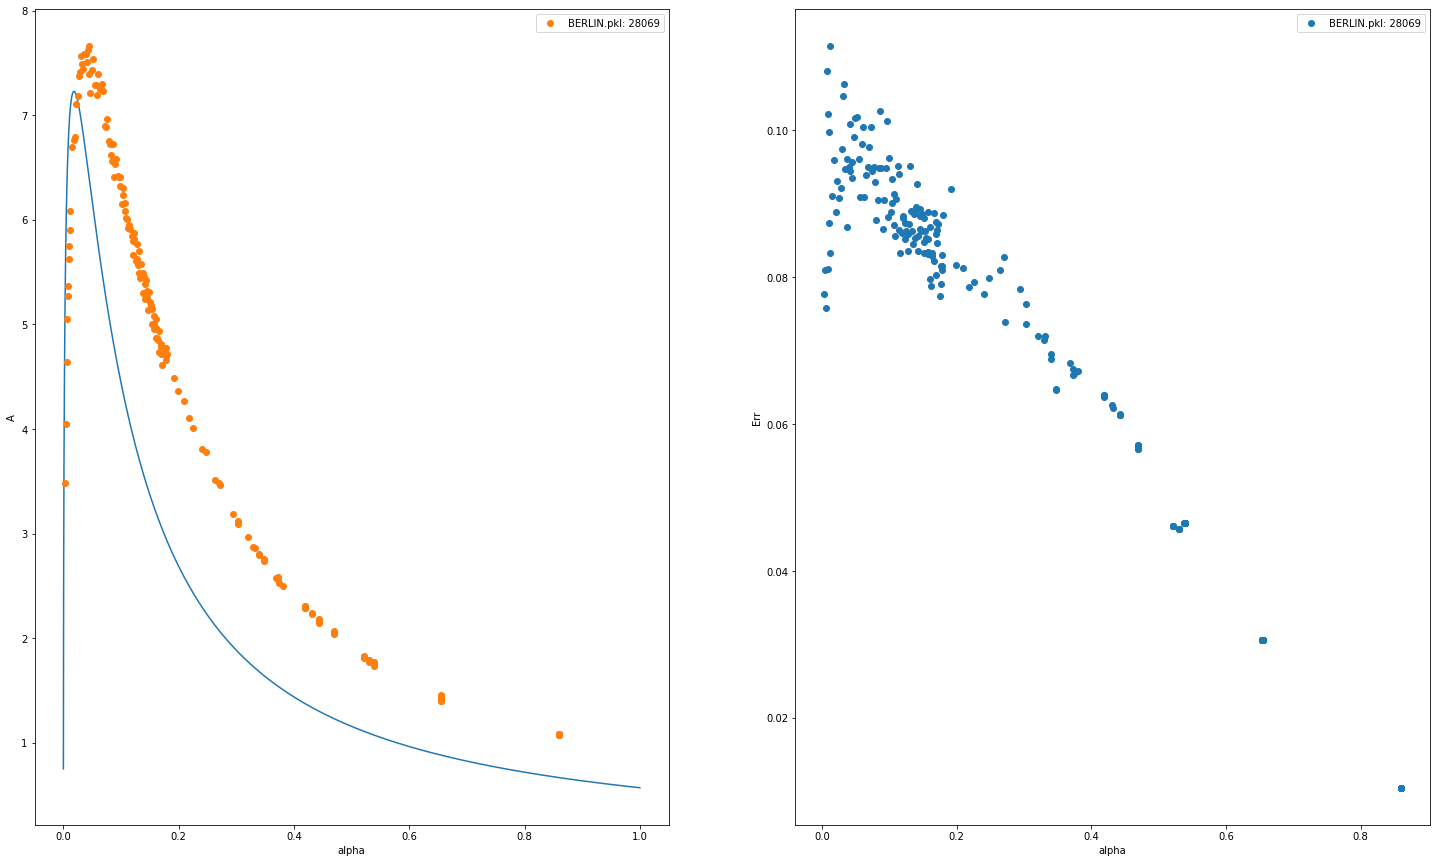

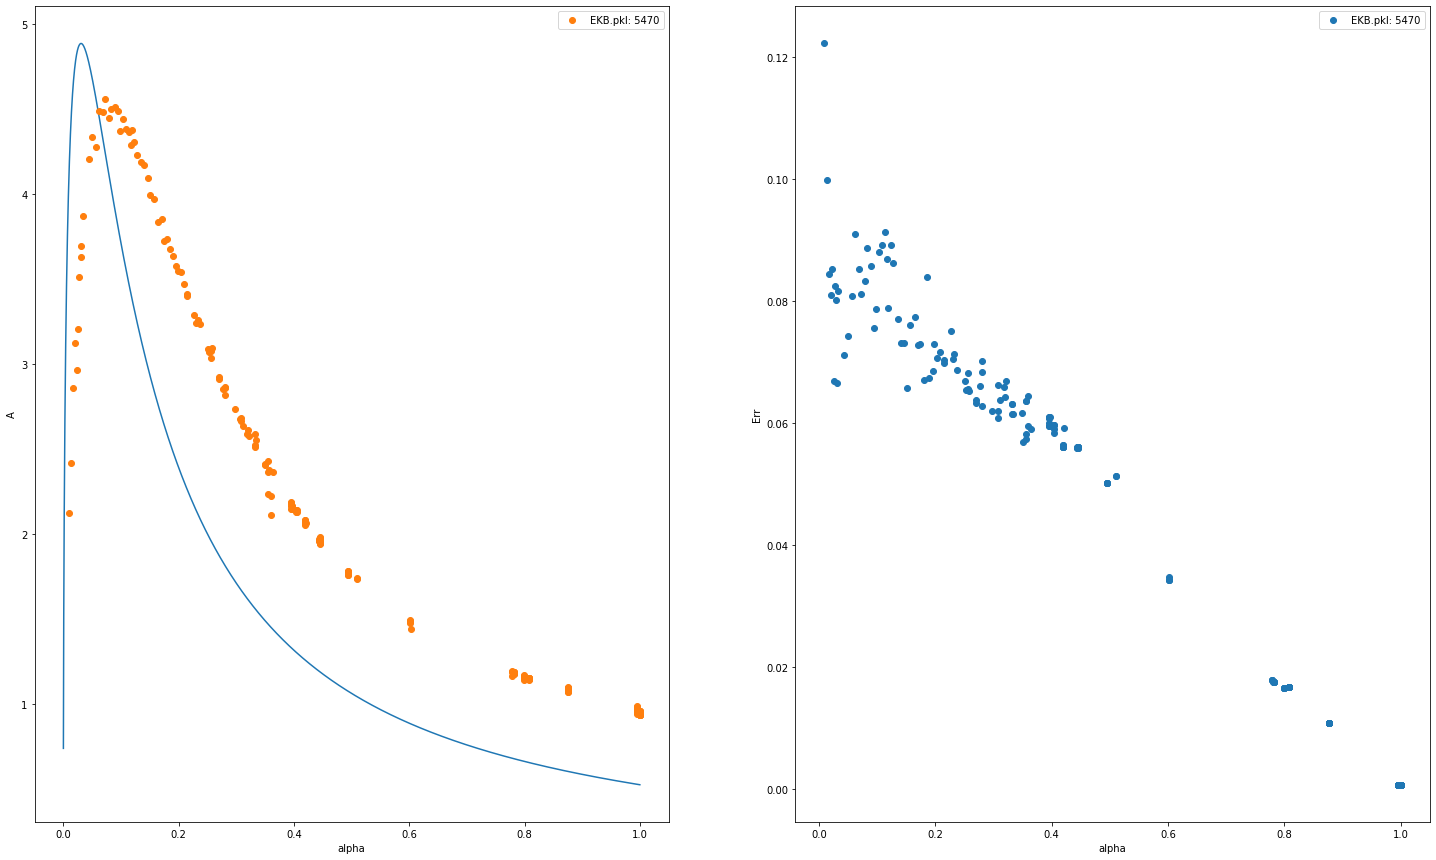

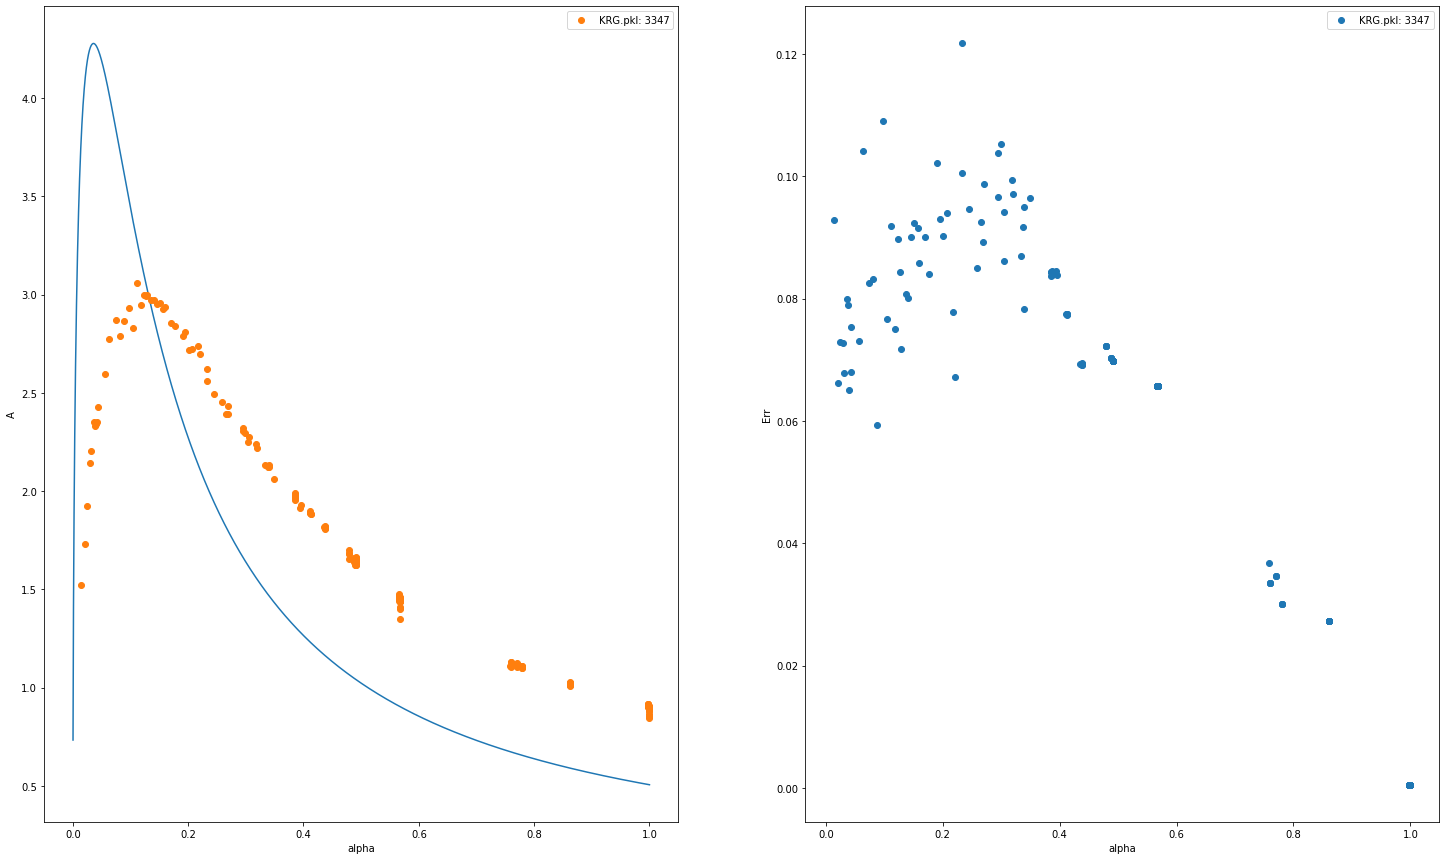

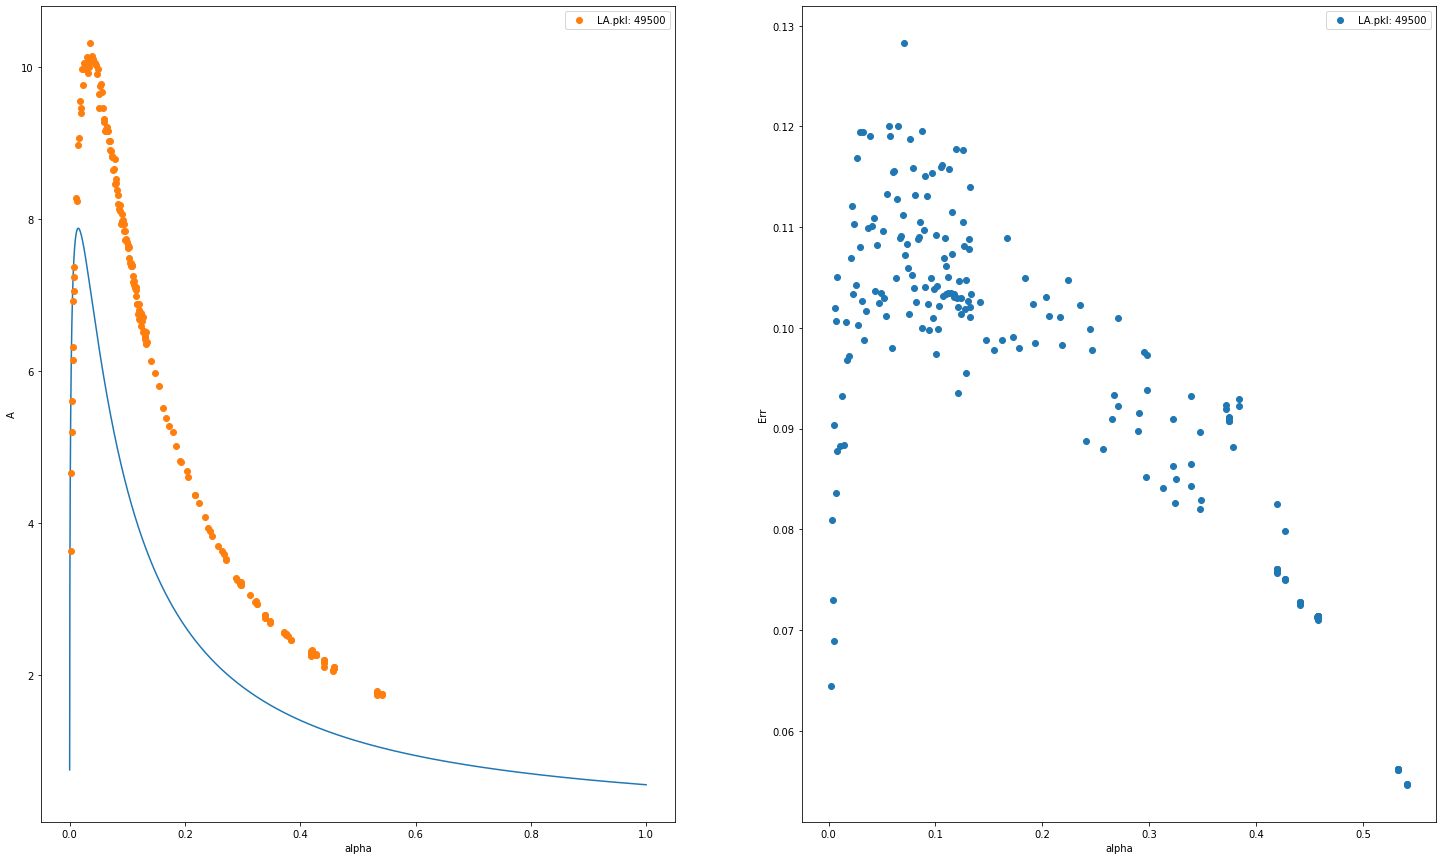

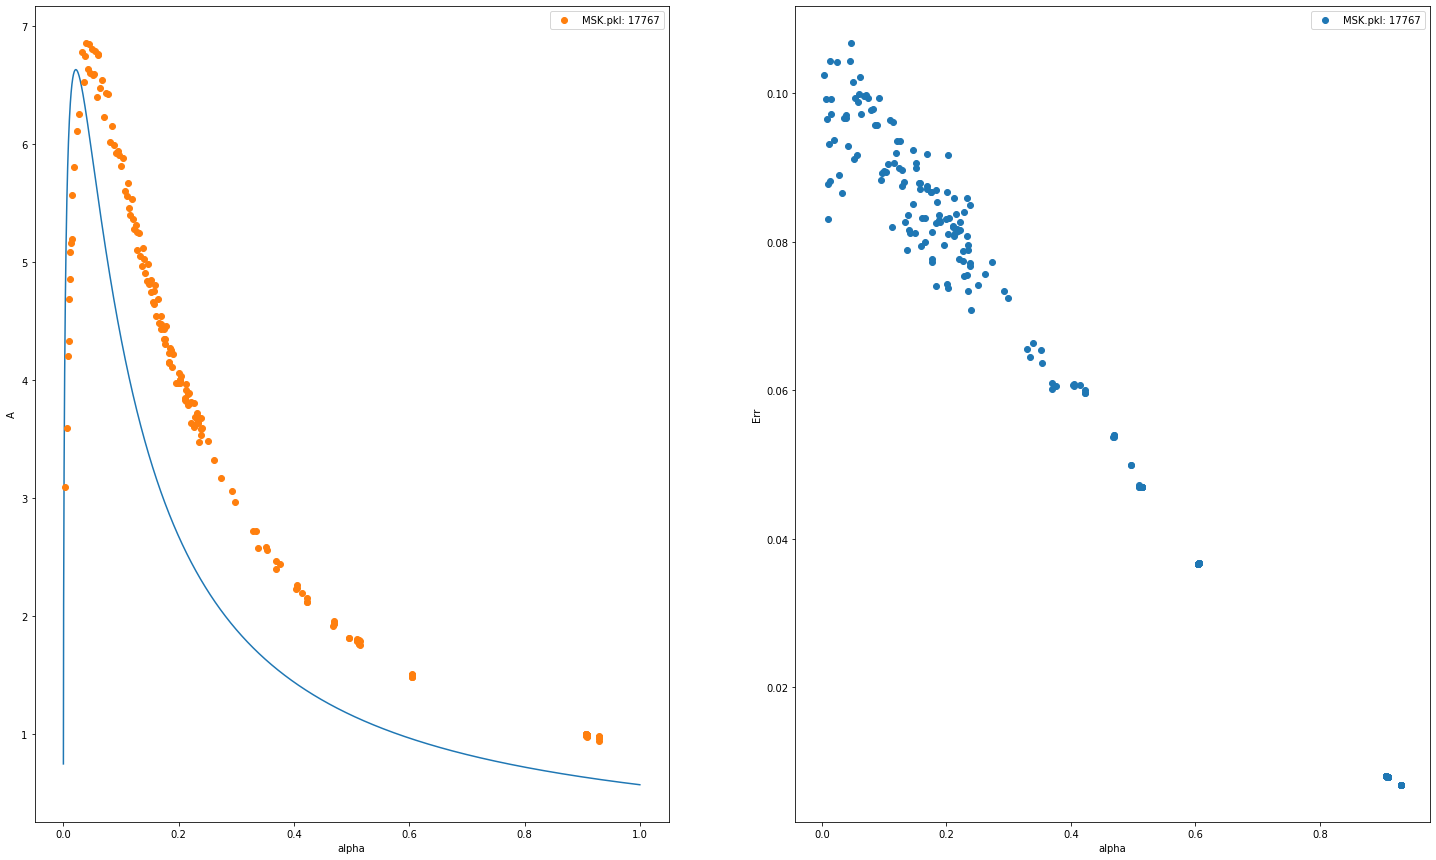

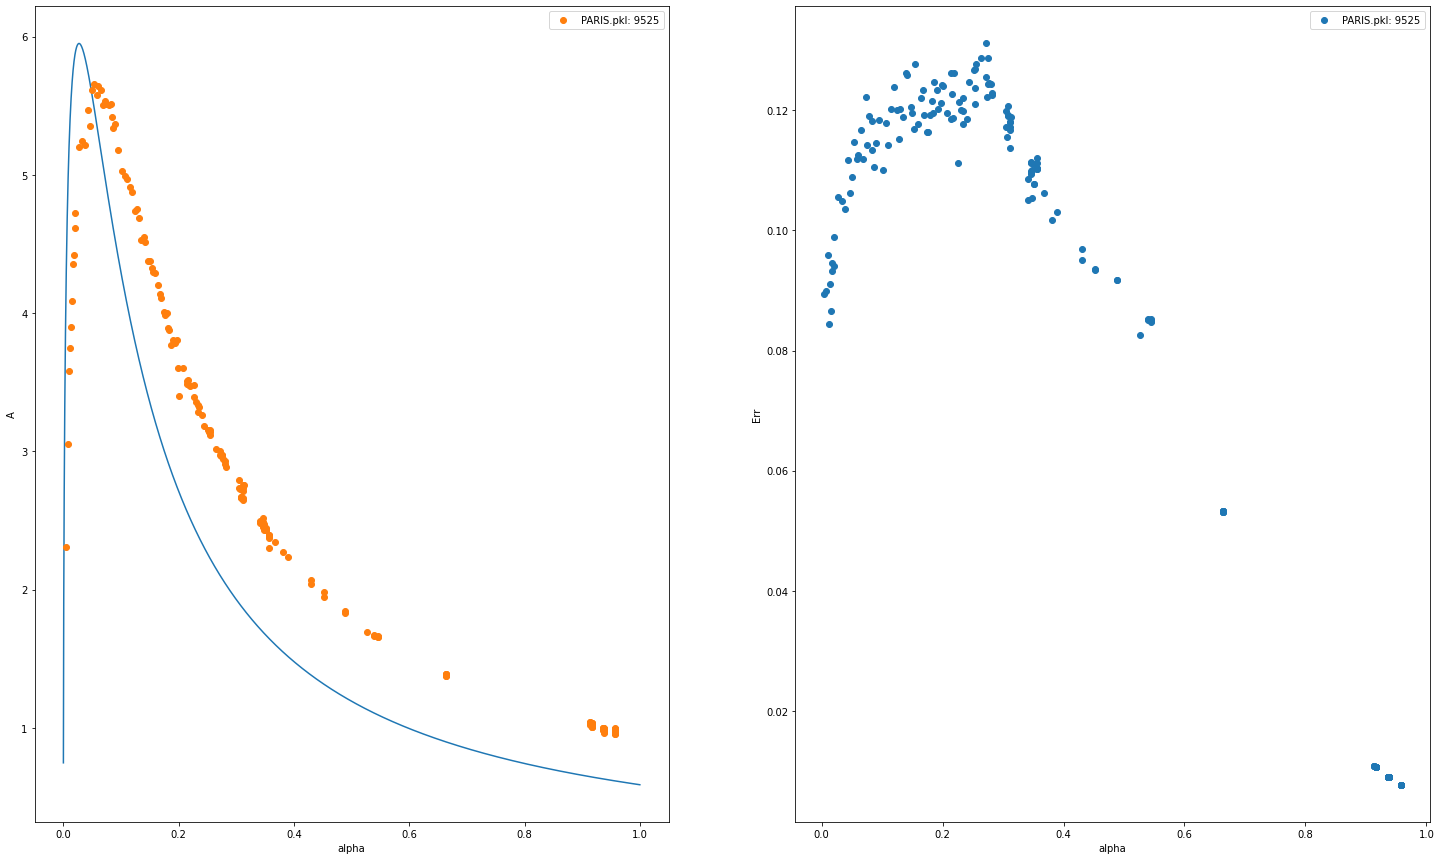

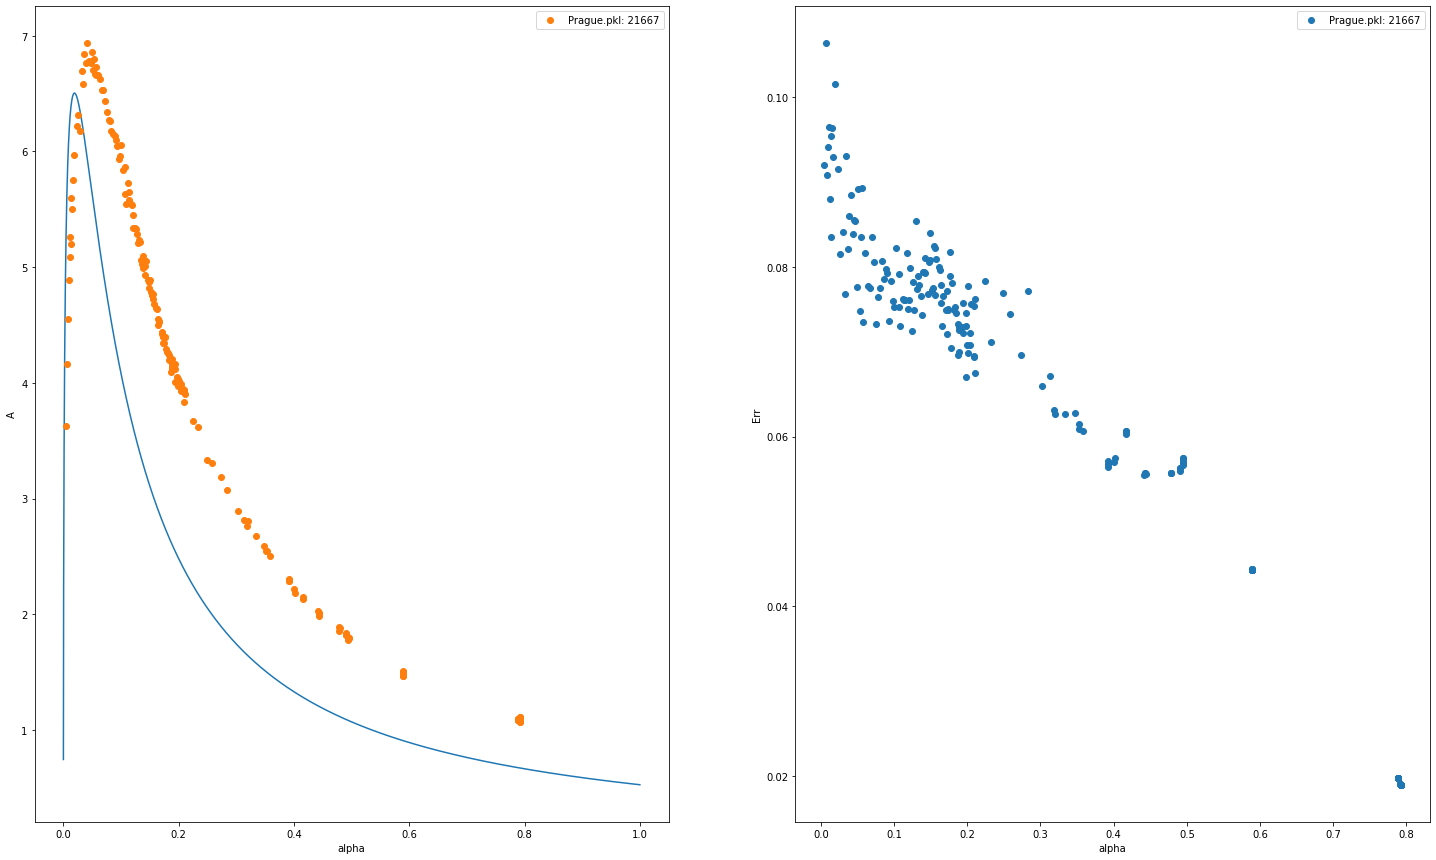

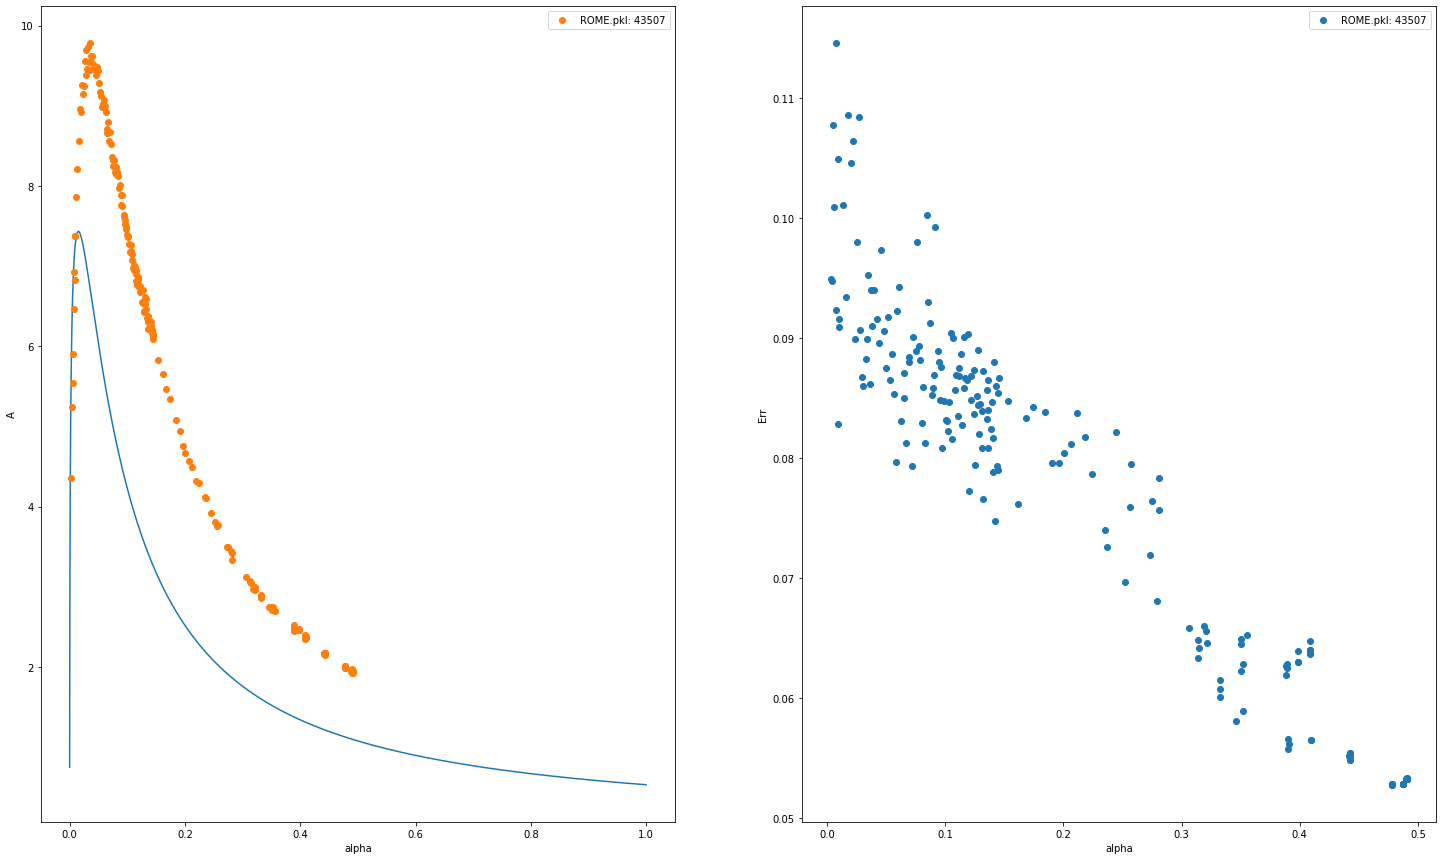

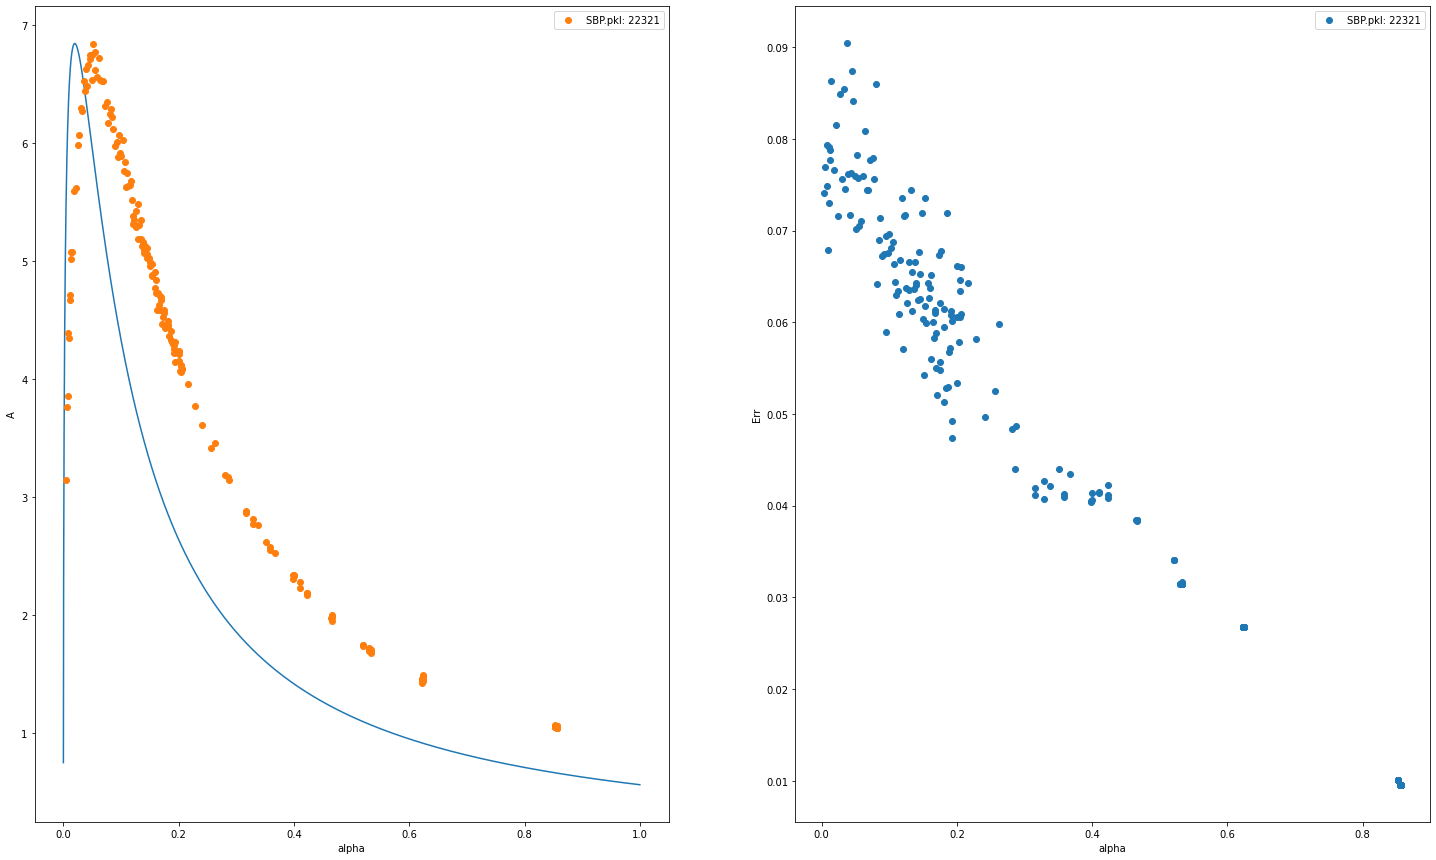

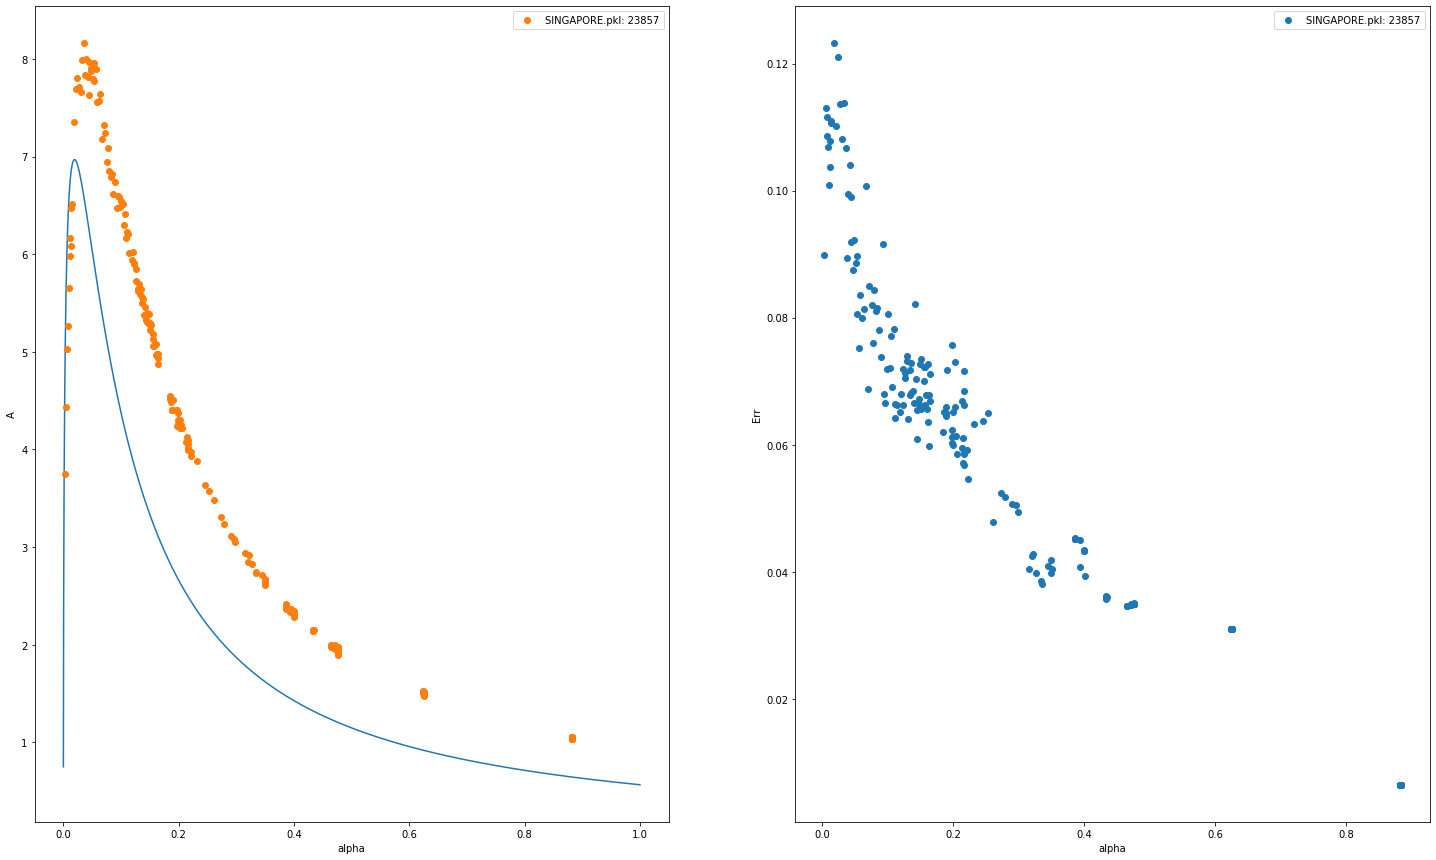

In [4]:
nodes = []
alpha_max = []
for name in r:
    res:CityResult = r[name]
    print('mean centroids b:', np.mean([p.centroid_edges/p.centroid_nodes for p in res.points_results]),'+-',
          np.std([p.centroid_edges/p.centroid_nodes for p in res.points_results]))
    X = [p.alpha for p in res.points_results]
    A = [p.speed_up[0] for p in res.points_results]
    E = [np.mean(p.errors) for p in res.points_results]

    fig, axs = plt.subplots(1, 2)
    fig.set_figwidth(25)
    fig.set_figheight(15)

    axs[1].errorbar(X, E, fmt='o', label = "{}: {}".format(name, r[name].nodes))
    axs[1].set(xlabel='alpha', ylabel='Err')
    axs[1].legend()

    alpha = np.argmax(A)
    alpha_max.append(X[alpha])
    nodes.append(res.nodes)
    N= res.nodes
    def ax(x):
        b1 = 2
        b0 = res.edges/res.nodes
        k = 0.8/(1/np.sqrt(x*N) -1/2*1/np.sqrt(x*N)*(1 + np.log(x)/np.log(N)) + b1/b0 * x * (1 + np.log(x)/np.log(N)) +1/(b0*np.log(N)))
        return k
    x = np.linspace(1/N,1,5000)
    y = ax(x)
    axs[0].errorbar(x, y)
    axs[0].errorbar(X, A, fmt='o', label = "{}: {}".format(name, r[name].nodes))
    axs[0].set(xlabel='alpha', ylabel='A')
    axs[0].legend()


    # print(res.nodes, X[alpha] )


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<ErrorbarContainer object of 3 artists>

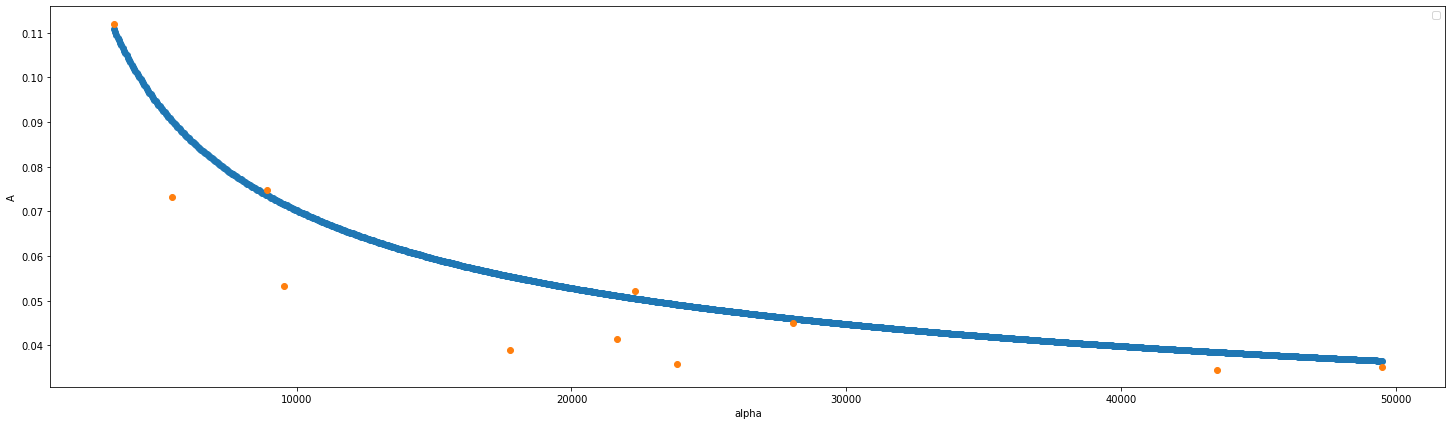

In [5]:
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(25)
fig.set_figheight(7)

axs.set(xlabel='alpha', ylabel='A')
axs.legend()

def f(x):
    return 2 ** (1/3) * np.log(4)/(4*np.log(x) + 12 + np.log(4)) / np.power(x, 1/3)
x = np.linspace(min(nodes), max(nodes), 1000)
y = 43.5*f(x)
axs.errorbar(x, y, fmt='o', label = "{}: {}".format(name, r[name].nodes))
axs.errorbar(nodes, alpha_max, fmt='o', label = "{}: {}".format(name, r[name].nodes))


In [6]:
print(f(10000)*2)
print(f(20000)*2)
print(f(30000)*2)
print(f(40000)*2)
print(f(50000)*2)
print(f(60000)*2)
print(f(70000)*2)


0.003228141336703652
0.0024281429184812306
0.002058195384227651
0.0018314121019733297
0.0016733524858744788
0.0015546762284228926
0.0014611120854724092


NameError: name 'func' is not defined

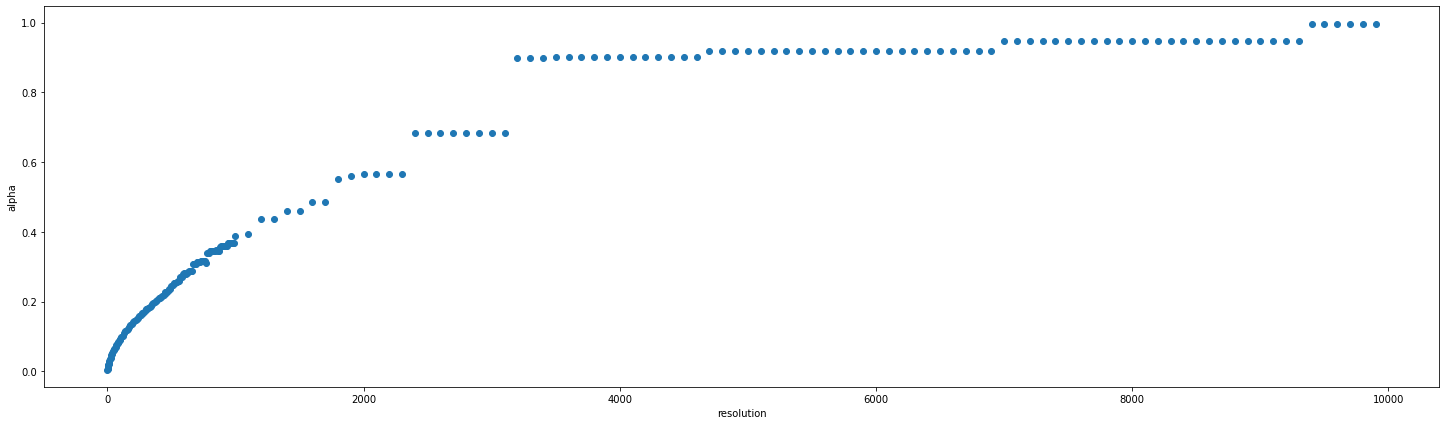

In [7]:
from common import CentroidResult
data = {'a' : [], 'b': [], 'N': [], 'density': []}
for name in r:
    res: CityResult = r[name]
    X_r = []
    Y_a = []
    for p_r in res.points_results:
        point_res : CentroidResult = p_r
        X_r.append(point_res.resolution)
        Y_a.append(point_res.alpha)

    fig, axs = plt.subplots(1, 1)
    fig.set_figwidth(25)
    fig.set_figheight(7)

    axs.errorbar(X_r, Y_a, fmt='o', label = "{}: {}".format(name, r[name].nodes))
    axs.set(xlabel='resolution', ylabel='alpha')

    popt = curve_fit(func, X_r, Y_a)
    XX = np.linspace(0,10000,10000)
    YY = func(XX, popt[0][0], popt[0][1])
    axs.errorbar(XX, YY)
    print(popt[0][0])
    data['a'].append(popt[0][0])
    data['b'].append(popt[0][1])
    data['N'].append(res.nodes)
    data['density'].append(res.density)

In [ ]:
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(25)
fig.set_figheight(7)

axs[0].errorbar( np.array(data['density']), data['a'], fmt='o')
axs[1].errorbar(np.array(data['density']) * np.array(data['N']) *(np.array(data['N'])-1), data['b'], fmt='o')

axs[2].errorbar(data['b'], data['a'], fmt='o')

x= np.array(data['density']) * np.array(data['N']) *(np.array(data['N'])-1)
popt = curve_fit(func, np.array(data['density']) * np.array(data['N']) *(np.array(data['N'])-1), data['b'],p0=[-2, 0.01])
XX = np.linspace(min(x),max(x),10000)
YY = func(XX, popt[0][0], popt[0][1])
axs[1].errorbar(XX, YY)

print(popt)

# axs.set(xlabel='resolution', ylabel='alpha')


In [ ]:
def theory_func(x,c, g, N = 9574, b0 = 1):
    x = x * c
    q = np.log(x) / np.log(N)
    return g / (x / b0 * (1 + q) + c / (np.sqrt(x * N)) * (1 - q))

In [ ]:
X_a = {}
Y_err = {}
Y_err_std = {}

Y_speedup = {}

for name in r:
    result: CityResult = r[name]
    X_a[name] = [a.alpha for a in result.points_results]
    Y_err[name] = [np.mean(a.errors) for a in result.points_results]
    Y_err_std[name] = [np.std(a.errors) for a in result.points_results]
    Y_speedup[name] = [np.mean(a.speed_up) for a in result.points_results]

Графики:

In [ ]:
city_to_n = {}
X_max = {}
Y_speedup_max = {}
Y_err_speedup = {}

c = {}
b = {}
for name in r:
    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(25)
    fig.set_figheight(7)

    axs[0].errorbar(X_a[name], Y_speedup[name], fmt='o', label = "{}: {}".format(name, r[name].nodes))
    axs[0].set(xlabel='alpha'+ str(r[name].density), ylabel='ускорение')

    func_r = partial(theory_func, N=r[name].nodes, b0=r[name].edges/r[name].nodes)
    print(str(r[name].nodes) + ' ' + str(r[name].edges/r[name].nodes))
    print(str(r[name].nodes) + ' ' + str(2*r[name].edges/(r[name].nodes * (r[name].nodes-1))))

    _x = np.array(X_a[name])
    _x = _x[_x < 0.6]
    _xx = np.linspace(min(_x), max(_x), 100)


    _y = np.array(Y_speedup[name])[0:len(_x)]
    popt = curve_fit(func_r, _x, _y, p0=[0.0003, 4],bounds=(0,[10,1000]))
    # if 'ASHA' in name:
    #     func_target = partial(theory_func, c=0.00005, g=25,N=r[name].nodes, b0=r[name].density)
    # else:
    func_target = partial(theory_func, c=popt[0][0], g=popt[0][1],N=r[name].nodes, b0=r[name].edges/r[name].nodes)
    a = scipy.optimize.fminbound(lambda x: -func_target(x), 0, 0.5)
    city_to_n[name] = r[name].nodes
    X_max[name] = a
    Y_speedup_max[name] = func_target(a)

    c[name] = popt[0][0]
    b[name] = popt[0][1]

    _y = func_target(np.array(_xx))
    axs[0].errorbar(_xx, _y, linewidth=3, label = "c:{}\n g:{}".format(popt[0][0],popt[0][1]))
    axs[0].legend()
    axs[1].errorbar(X_a[name], Y_err[name], fmt='o')
    axs[1].set(xlabel='alpha' + str(r[name].density), ylabel='средняя относительная ошибка')
    z = np.polyfit(X_a[name], Y_err[name], 6)
    p = np.poly1d(z)
    axs[1].errorbar(_xx, p(_xx), fmt='o')
    Y_err_speedup[name] = p(a)



    axs[2].errorbar(X_a[name], Y_err_std[name], fmt='o')
    axs[2].set(xlabel='alpha'+ str(r[name].density), ylabel='погрешность ошибки')

    # file_name = generate_new_name(name + '.png', 'plots')

    # plt.savefig(file_name)

Построим график ускорения от плотности

In [ ]:
# X_max = {}
# Y_speedup_max = {}
# Y_err_speedup = {}

def t_f(x, N, b):
    return

fig, axs = plt.subplots(1, 5)
fig.set_figwidth(30)
fig.set_figheight(7)


X_betta = [city_to_n[name] for name in city_to_n]
Y_betta_speedup =[Y_speedup_max[n] for n in Y_speedup_max]
Y_betta_err =[Y_err_speedup[n] for n in Y_err_speedup]

Y_c = [c[name] for name in c]
Y_b = [b[name] for name in b]

axs[0].errorbar(X_betta, Y_betta_speedup, fmt='o')
axs[0].set(xlabel='плотность', ylabel='максимальное ускорение')


axs[1].errorbar(X_betta, Y_betta_err, fmt='o')
axs[1].set(xlabel='плотность', ylabel='относительная ошибка при максимаольном кскорении')



axs[2].errorbar(X_betta, Y_c, fmt='o')
axs[2].set(xlabel='плотность', ylabel='c')
X_betta = [r[n].density for n in r]

axs[3].errorbar(X_betta, Y_b, fmt='o')
axs[3].set(xlabel='плотность', ylabel='b')


axs[4].errorbar(X_betta, [X_max[name] for name in X_max], fmt='o')
axs[4].set(xlabel='плотность', ylabel='alpha')

plt.show()

In [ ]:
def line(x, a,b):
    return a*x + b

def line_predict(x, a,b,alpha, N):
    # print("a:{:.2f} n:{:.2f}".format(alpha, N))
    return a*x/(alpha * (1 + np.log(alpha)/np.log(N))) + b

def inverse(x,a,b,c):
    return a*(x**c) + b

Уберем последние 4 точки

In [ ]:
# X_max = {}
# Y_speedup_max = {}
# Y_err_speedup = {}

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(25)
fig.set_figheight(7)

X_max_1 = dict(list(X_max.items())[0:-5])
X_betta = [r[n].density for n in r][0:-5]
Y_betta_speedup =[Y_speedup_max[n] for n in Y_speedup_max][0:-5]
Y_betta_err =[Y_err_speedup[n] for n in Y_err_speedup][0:-5]

axs[0].errorbar(X_betta, Y_betta_speedup, fmt='o')
axs[0].set(xlabel='плотность', ylabel='максимальное ускорение')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X_betta,Y_betta_speedup)

_x = np.linspace(min(X_betta), max(X_betta))
_y = slope * _x + intercept
axs[0].errorbar(_x, _y,label = '{:.2f}x + {:.2f}. R2:{:.4f}'.format(slope,intercept, r_value**2))
axs[0].legend()


# _x = X_betta
# f = partial(line_predict, N = [r[name].nodes for name in r][0])
# _y = []
# for i,a in enumerate(X_max_1):
#     _y.append(f(_x[i], slope/15, intercept, X_max_1[a]))
#
# axs[0].errorbar(_x, _y, fmt = 'o')
# axs[0].legend()



axs[1].errorbar(X_betta, Y_betta_err, fmt='o')
axs[1].set(xlabel='плотность', ylabel='относительная ошибка при максимаольном кскорении')

popt = curve_fit(inverse, X_betta, Y_betta_err, p0=[0.000000015, -1.5,0.06])
_xx = np.linspace(min(X_betta), max(X_betta), 300)
_yy = inverse(_xx, *popt[0])
axs[1].errorbar(_xx, _yy,label = '{:.10f}x^(-2) + {:.4f}'.format(popt[0][0],popt[0][1]))
axs[1].legend()
plt.show()

In [ ]:
from graph_generator import get_graph

H = get_graph('R2555133')


In [ ]:
def _f(x, N):
    q = np.log(x) / np.log(N)
    return 1 / (x * (1 + q) + 1 / (np.sqrt(x * N)) * (1 - q))

for name in r:
    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(25)
    fig.set_figheight(7)

    axs[0].errorbar(X_a[name], Y_speedup[name], fmt='o', label = "{}: {}".format(name, r[name].nodes))
    axs[0].set(xlabel='alpha'+ str(r[name].density), ylabel='ускорение')

    # func_r = partial(theory_func, N=r[name].nodes, b0=r[name].edges/r[name].nodes)
    # print(str(r[name].nodes) + ' ' + str(r[name].edges/r[name].nodes))
    # print(str(r[name].nodes) + ' ' + str(2*r[name].edges/(r[name].nodes * (r[name].nodes-1))))

    _x = np.array(X_a[name])
    _x = _x[_x < 0.6]
    _xx = np.linspace(min(_x), max(_x), 100)

    func_target = partial(_f, N=r[name].nodes)
    _y = func_target(np.array(_xx))
    axs[0].errorbar(_xx, _y, linewidth=3)
    axs[0].legend()
    # axs[1].errorbar(X_a[name], Y_err[name], fmt='o')
    # axs[1].set(xlabel='alpha' + str(r[name].density), ylabel='средняя относительная ошибка')
    # z = np.polyfit(X_a[name], Y_err[name], 6)
    # p = np.poly1d(z)
    # axs[1].errorbar(_xx, p(_xx), fmt='o')
    # Y_err_speedup[name] = p(a)
    #
    #
    #
    # axs[2].errorbar(X_a[name], Y_err_std[name], fmt='o')
    # axs[2].set(xlabel='alpha'+ str(r[name].density), ylabel='погрешность ошибки')

    # file_name = generate_new_name(name + '.png', 'plots')

    # plt.savefig(file_name)

In [ ]:
def _f(x, N):
    q = np.log(x) / np.log(N)
    return 1 / (x * (1 + q) + 1 / (2*np.sqrt(x * N)) * (1 - q))

arr_N = [i for i in range(10000, 100000,100)]
y = []
for i in arr_N:
    func_target = partial(_f, N=i)
    a = scipy.optimize.fminbound(lambda x: -func_target(x), 0, 1)
    y.append(func_target(a))

fig, axs = plt.subplots(1, 1)
fig.set_figwidth(25)
fig.set_figheight(7)

axs.errorbar(arr_N, y, linewidth=3,label='a')
axs.errorbar(arr_N, (np.array(arr_N)) ** 0.317 -1.5, linewidth=3, label = 'b')
axs.legend()
